# How to Fit a Step? 
## Test example

We are going to use scipy to create a data having a step, i.e. a y-offset. The data will be the combination of two samples of 300 element each:

* DataA with x-values between [0,10] and with y-value normally distributed around -0.5, with a dispersion of 0.6 ; each point has a y-err of 0.3.

* DataB with x-values between [10,20] and with y-value normally distributed around 0.7, with a dispersion of 0.7 ; each point has a y-err of 0.4.


#### Basic ipython notebook import 

In [19]:
# plot within the notebook
%matplotlib inline
import warnings
# No annoying warnings
warnings.filterwarnings('ignore')
# Because we always need that
import numpy as np

## Creation of the data points

In [13]:
# Structure of the _data: [x,y,yerr]
npointa,npointb = 100,100

adata = np.asarray([np.random.rand(npointa)*10, np.random.normal(loc=-0.5,scale=0.6,size=npointa), [0.3]*npointa])
bdata = np.asarray([np.random.rand(npointb)*10+10, np.random.normal(loc=0.7,scale=0.7,size=npointb), [0.5]*npointb])


Let's see how it looks like

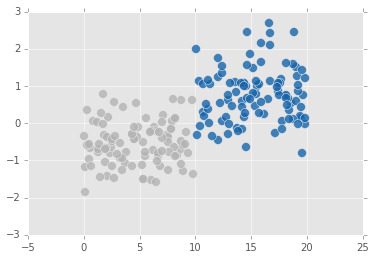

In [14]:
import matplotlib.pyplot as mpl
mpl.style.use('ggplot')
mpl.scatter(adata[0],adata[1], s=80, facecolors=mpl.cm.binary(0.3,0.8))
mpl.scatter(bdata[0],bdata[1], s=80, facecolors=mpl.cm.Blues(0.8,0.8))

# Fit the Step `modefit.stepfit`

In [15]:
import modefit

Load the stepfit object that enables the fit

In [16]:
step = modefit.stepfit(np.concatenate([adata[0],bdata[0]]), 
                           np.concatenate([adata[1],bdata[1]]), 
                           np.concatenate([adata[2],bdata[2]]),
                          xcut = 10)

Perform the fit and provide the initial conditions. You have 3 model's parameter characteristics you can set:

* x`_guess` : initial guess for the "x" parameter
* x`_boundaries`: fit boundaries for the "x" parameter
* x`_fixed`: Set this to True to fixe the parameter to its `_guess` value

"x" could be any `freeparamters` of the model. You do not have to fill the entries

In [17]:
step.fit(sigma_a_guess=0.5,sigma_b_guess=0.5, mean_a_guess=-.5,mean_b_guess=0.5)

STARTS MINUIT FIT


FCN = 385.611712917 
 TOTAL NCALL = 79 
 NCALLS = 79 
 
 
 EDM = 4.54753371567e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,mean_a,-0.539177,0.0565716,0,0,,,
2,sigma_a,0.479619,0.0471806,0,0,,,
3,mean_b,0.757153,0.0711614,0,0,,,
4,sigma_b,0.506354,0.0707145,0,0,,,


Now that fit has been performed, you best fitted values will be displayed in the plot

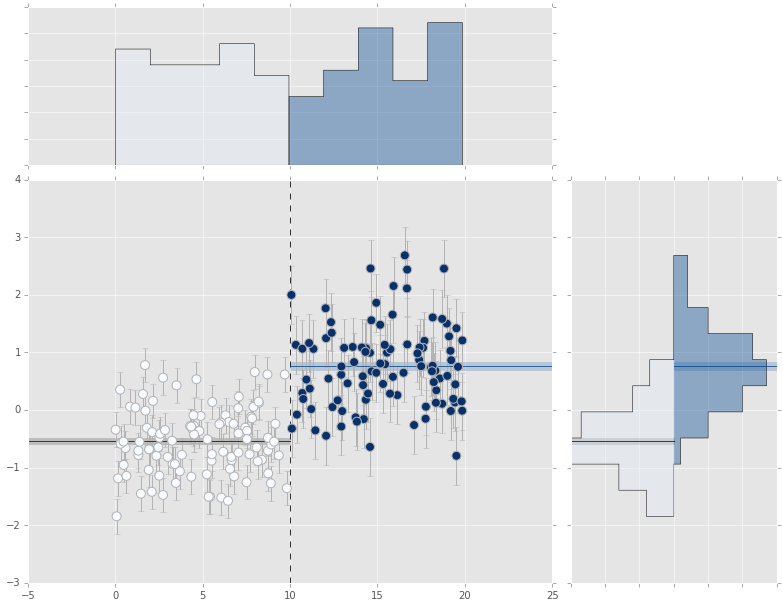

In [18]:
step.show(cmap=mpl.cm.Blues_r)

#### Access the best fitted Values

A dictionary containing the fitted values is accessible by the `fitvalues` property

In [15]:
step.fitvalues

{'chi2': 899.8818884630228,
 'mean_a': -0.8504420926798395,
 'mean_a.err': 0.18860032362460522,
 'mean_b': 1.2375707041151038,
 'mean_b.err': 0.27927552352081314,
 'sigma_a': 1.1432430743511546,
 'sigma_a.err': 0.22000395917444546,
 'sigma_b': 1.9492240945389525,
 'sigma_b.err': 0.28292549090266411}

# MCMC approach

A mcmc package is included in the models and fitter. By default, the prior information are flat (no prior information). Change that by inheriting the class to create your own!

*careful, this is much slower*

In [16]:
step.run_mcmc(500)

Traceback (most recent call last):
  File "//anaconda/lib/python2.7/site-packages/emcee/ensemble.py", line 505, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/mrigault/Libraries/modefit/fitter/virtualfitter.py", line 588, in lnprob
    return priors - 0.5*self.get_chi2(parameters)
  File "/Users/mrigault/Libraries/modefit/fitter/bimodalfitter.py", line 195, in get_modelchi2
    return -2 * self.model.get_loglikelihood(self.data,self.errors,self.proba)
  File "/Users/mrigault/Libraries/modefit/fitter/bimodalfitter.py", line 321, in get_loglikelihood
    for x_,y_,p_ in zip(x,dx,p)] )
  File "/Users/mrigault/Libraries/modefit/fitter/bimodalfitter.py", line 327, in _get_case_likelihood_
    return p * stats.norm(loc=self.mean_a,scale=np.sqrt(self.sigma_a**2 + dx**2)).pdf(x) + \
  File "//anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py", line 744, in __call__
    return self.freeze(*args, **kwds)
  File "//anaconda/lib/python2.7/site-pa

emcee: Exception while calling your likelihood function:
  params: [-0.62148548  1.41155554  1.3938679   1.35878845]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [ ]:
print 2